<a href="https://colab.research.google.com/github/parament-integrator/examples/blob/master/Convergence_Plot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Convergence plot

In this example we will recreate the convergence plot from our paper.

A convergence plot shows the residual error of the numeric integration vs the number of time steps.

The problem we are integrating is one where an analytical solution is know, namely a spin singlet that is driven by a cicularly polarized field. It's Hamiltonian is given by:

$$ \mathcal{H}/h = \frac{\omega_0}{2} \sigma_z + \cos(\omega_\mathrm{rf} t) \frac{\omega_1}{2}\sigma_x  + \sin(\omega_\mathrm{rf} t) \frac{\omega_1}{2}\sigma_y  = H_0 + u_1(t)\cdot H_1 + u_2(t)\cdot  H_2$$

where $\sigma_x$, $\sigma_y$, $\sigma_z$ are the Pauli matrices. $u_1$ and $u_2$ are the control amplitudes, and represent the applied magnetic fields. For convenience, we set the Planck constant $h=1$. 

---


## Install dependencies


As a first step, we must prepare the environment. We install `parament` via `pip`.

The `NVCC_ARGS="-arch=compute_37"` part instructs the compiler to target older GPUs as well, to maximize compatibility. This is necessary on Google Colab, as sometimes you will be assigned a fairly old Tesla K80 GPU that is not targeted by the default.

In [1]:
!NVCC_ARGS="-arch=compute_37" pip install git+https://github.com/parament-integrator/parament#subdirectory=src

  Cloning https://github.com/parament-integrator/parament to /tmp/pip-req-build-4_6vgiq_
  Running command git clone -q https://github.com/parament-integrator/parament /tmp/pip-req-build-4_6vgiq_
  Created wheel for parament: filename=parament-0.1-py3-none-linux_x86_64.whl size=784107 sha256=11ab0762e5fffddaada95de650ce8f3e158b8a837daf84ec954ef705a66c35a8
  Stored in directory: /tmp/pip-ephem-wheel-cache-mdeso520/wheels/30/d6/35/c1497ea3f67415126ff9dcde263bc6c57e63b2e80d38e99fc5
Successfully built parament


We can now import the packages we need.

In [2]:
import parament
import numpy as np
import scipy.linalg
import matplotlib.pyplot as plt

Next, we define the Hamiltonian, according to the equation above.

In [3]:
dtype_base = np.complex128

ox = np.array([[0, 1], [1, 0]], dtype=dtype_base)
oy = np.array([[0, -1j], [1j, 0]], dtype=dtype_base)
oz = np.array([[1, 0], [0, -1]], dtype=dtype_base)
oe = np.array([[1, 0], [0, 1]], dtype=dtype_base)

w0 = 1.0
w1 = 0.1
wrf = 1.0
TSTOP = 6

H0 = w0/2 * oz
H1 = w1/2 * ox
H2 = w1/2 * oy

As mentioned, for this particular problem, the exact solution is known:

In [4]:
def Uexact(t):
    dw = w0 - wrf
    gen = np.sqrt(w1**2+dw**2)
    explabM = np.exp(-0.5j*t*wrf)
    explabP = np.exp(0.5j*t*wrf)
    x = 0.5*gen*t
    fact1 = dw/gen
    fact2 = w1/gen
    M1 = explabM*(np.cos(x) + 1j*fact1 * np.sin(x))
    M2 = explabM*(-1j*fact2*np.sin(x))
    M3 = explabP*(-1j*fact2*np.sin(x))
    M4 = explabP*(np.cos(x) - 1j*fact1 * np.sin(x))  
    return np.array([[M1, M2],[M3, M4]])
    

We can now run parament on the same hamiltonian, and compare the output.

In [5]:
def compare(GPURunner, pts, magnus, quad):
    GPURunner.set_hamiltonian(H0, H1, H2, use_magnus=magnus, quadrature_mode=quad)
    t = np.linspace(0, TSTOP, pts)
    dt = t[1] - t[0]
    carr1 = np.cos(wrf*t)
    carr2 = np.sin(wrf*t)
    propagator_numeric = GPURunner.equiprop(dt, carr1, carr2)
    propagator_exact = Uexact(TSTOP)
    Qdiff = propagator_numeric - propagator_exact
    norm_diff = np.linalg.norm(Qdiff)
    return norm_diff

First we'll try single precision...

In [6]:
steps = np.logspace(1, 4.5, dtype=int)
steps = np.array([s+1 if s%2 == 0 else s for s in steps])

with parament.Parament(precision='fp32') as GPURunner:
  y1 = np.array([compare(GPURunner, step, True, 'simpson') for step in steps])
  y2 = np.array([compare(GPURunner, step, False, 'midpoint') for step in steps])
  y3 = np.array([compare(GPURunner, step, False, 'simpson') for step in steps])

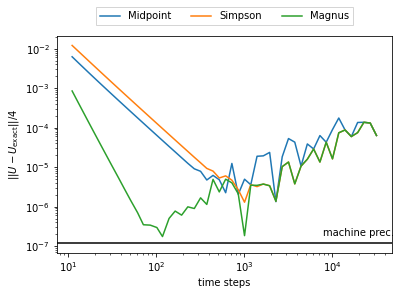

In [7]:
plt.figure()
plt.loglog(steps, np.array(y2)/4, label='Midpoint')
plt.loglog(steps, np.array(y3)/4, label='Simpson')
plt.loglog(steps, np.array(y1)/4, label='Magnus')
plt.ylabel('$||U-U_\mathrm{exact}||/4$')
plt.xlabel('time steps')
plt.axhline(2**-23, c='k')
plt.text(5e4, 1.5*2**-23, 'machine prec.', ha='right')
plt.legend(loc='lower center', bbox_to_anchor=(0.5, 1.025),
           ncol=3, fancybox=False, shadow=False)
plt.plot()
plt.show()

And double precision next...

In [8]:
steps = np.array([
            13,      15,      21,      25,      33,      41,      51,
            65,      83,     105,     131,     167,     211,     267,
           337,     427,     541,     683,     865,    1093,    1383,
          1749,    2217,    2799,    3539,    4477,    5663,    7163,
          9061,   11459,   14495,   18335,   23191,   29333,   37101,
         46927,   59357,   75077,   94963,  120113,  151927,  192165,
        243061,  307437,  388863,  491855,  622125,  786897,  995311,
       1258925
])

In [9]:
with parament.Parament(precision='fp64') as GPURunner:
  z1 = np.array([compare(GPURunner, step, True, 'simpson') for step in steps])
  z2 = np.array([compare(GPURunner, step, False, 'midpoint') for step in steps])
  z3 = np.array([compare(GPURunner, step, False, 'simpson') for step in steps])

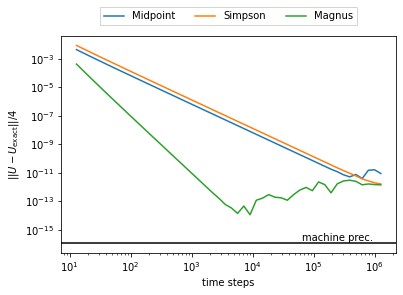

In [10]:
plt.figure()
plt.loglog(steps, np.clip(np.array(z2)/4, 2**-53,100), label='Midpoint')
plt.loglog(steps, np.clip(np.array(z3)/4, 2**-53,100), label='Simpson')
plt.loglog(steps, np.clip(np.array(z1)/4, 2**-53,100), label='Magnus')
plt.ylabel('$||U-U_\mathrm{exact}||/4$')
plt.xlabel('time steps')
plt.axhline(2**-53, c='k')
plt.text(6.5e4, 1.5*2**-53, 'machine prec.')
plt.legend(loc='lower center', bbox_to_anchor=(0.5, 1.025),
           ncol=3, fancybox=False, shadow=False)
plt.plot()
plt.show()